# Create training/validation/test pipeline

## Import modules

In [1]:
import os
import math
import glob
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter, map_coordinates

## Define global constants

In [2]:
image_dir = '../datasets/pathologocal_images_JPEG'
label_dir = '../datasets/ndarray_labels'
image_ext = '.jpg'
label_ext = '.npy'
model_input_shape = np.array([512, 512, 3])
batch_size = 16
random_seed = 0
validation_ratio = 0.2
num_epochs = 20

## Load sample name list

In [3]:
train_val_sample_names_path = '../datasets/train_val.txt'
test_sample_names_path = '../datasets/test.txt'
train_val_sample_names_file = open(train_val_sample_names_path)
train_val_sample_names = train_val_sample_names_file.read().splitlines()
test_sample_names_file = open(test_sample_names_path)
test_sample_names = test_sample_names_file.read().splitlines()

## Split sample names into training sample names and validation sample names

In [4]:
training_sample_names, validation_sample_names = train_test_split(
    train_val_sample_names,
    test_size=validation_ratio,
    random_state=random_seed
)

## Create pipelines

### Define function to preprocess data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


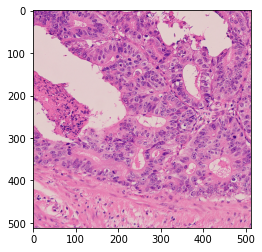

label -> 1


In [6]:
def load_label_array(array_path_tensor):
    array_path = array_path_tensor.numpy()
    label_array = np.load(array_path)
    return label_array

def load_and_preprocess_image(sample_name):
    magnification = 2
    brightness_max_delta = 0.1
    outer_size = magnification*model_input_shape[0]
    crop_origins = tf.random.uniform(
        (2,), 
        minval=0, 
        maxval=outer_size-model_input_shape[0], 
        dtype=tf.dtypes.int32
    )
    image_path = image_dir + '/' + sample_name + image_ext
    raw_image = tf.io.read_file(image_path)
    image_tensor = tf.image.decode_jpeg(raw_image)
    image_tensor = tf.image.resize(image_tensor, magnification*model_input_shape[:2])
    image_tensor = image_tensor[
        crop_origins[0]:crop_origins[0]+model_input_shape[0],
        crop_origins[1]:crop_origins[1]+model_input_shape[1],
        :
    ]
    image_tensor /= 255.0
    image_tensor = tf.image.random_flip_left_right(image_tensor, seed=None)
    image_tensor = tf.image.random_flip_up_down(image_tensor, seed=None)
    image_tensor = tf.image.random_brightness(image_tensor, brightness_max_delta)
    label_array_path = label_dir + '/' + sample_name + label_ext
    label_tensor = tf.py_function(func=load_label_array, inp=[label_array_path], Tout=tf.uint8)
    label_tensor = label_tensor[ ..., tf.newaxis]
    label_tensor.set_shape([630,630,1])
    label_tensor = tf.image.resize(label_tensor, magnification*model_input_shape[:2])[...,0]
    label_tensor = tf.slice(label_tensor, crop_origins, model_input_shape[:2])
    label = tf.cast(tf.math.reduce_sum(tf.cast(label_tensor==2, tf.int32))>0, tf.int32)
    return image_tensor, label

sample_name = training_sample_names[10]
preprocessed_image_tensor, label = load_and_preprocess_image(sample_name)
plt.imshow(preprocessed_image_tensor)
plt.show()
print('label -> {}'.format(label))

### Create training pipeline

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
num_training_samples = len(training_sample_names)
training_sample_name_dataset = tf.data.Dataset.from_tensor_slices(training_sample_names)
training_pipeline = (
    training_sample_name_dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
        .cache()
        .apply(tf.data.experimental.shuffle_and_repeat(buffer_size=num_training_samples))
        .batch(batch_size)
        .prefetch(buffer_size=AUTOTUNE)
)
training_steps_per_epoch=tf.math.ceil(num_training_samples/batch_size).numpy()

Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


### Create validation pipeline

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
num_validation_samples = len(validation_sample_names)
validation_sample_name_dataset = tf.data.Dataset.from_tensor_slices(validation_sample_names)
validation_pipeline = (
    validation_sample_name_dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
        .cache()
        .apply(tf.data.experimental.shuffle_and_repeat(buffer_size=num_validation_samples))
        .batch(batch_size)
        .prefetch(buffer_size=AUTOTUNE)
)
validation_steps_per_epoch=tf.math.ceil(num_validation_samples/batch_size).numpy()

### Create test pipeline

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
num_test_samples = len(test_sample_names)
test_sample_name_dataset = tf.data.Dataset.from_tensor_slices(test_sample_names)
test_pipeline = (
    test_sample_name_dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
        .cache()
        .batch(batch_size)
        .prefetch(buffer_size=AUTOTUNE)
)

## Create model

In [10]:
input_tensor = tf.keras.Input(shape=model_input_shape)
vgg16 =  tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)
x = vgg16.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs=vgg16.input, outputs=x)

## Compile model

In [12]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
)
loss_fn = tf.keras.losses.BinaryCrossentropy()
model.compile(
    loss=loss_fn,
    optimizer=optimizer,
    metrics=['accuracy']
)

## Train model

In [ ]:
history = model.fit(
    training_pipeline, 
    epochs=num_epochs, 
    steps_per_epoch=training_steps_per_epoch, 
    validation_data=validation_pipeline, 
    validation_steps=validation_steps_per_epoch
)

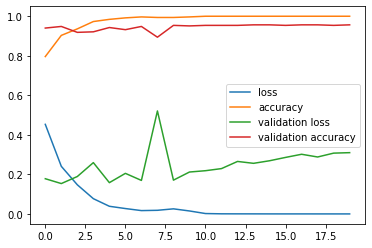

In [64]:
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_accuracy'])
plt.legend(['loss', 'accuracy', 'validation loss', 'validation accuracy'])

## Evaluate model with test samples

13/13 [==============================] - 1s 109ms/step - loss: 0.1836 - accuracy: 0.9704
test_resluts -> [0.18363627791404724, 0.9704433679580688]


,Normal,Tumor
Normal,112,2
Tumor,4,85


Text(33.0, 0.5, 'True')

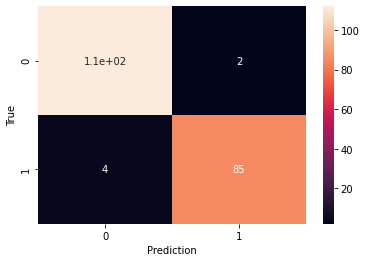

In [112]:
test_resluts = model.evaluate(test_pipeline)
print('test_resluts -> {}'.format(test_resluts))
test_predictions = model.predict(test_pipeline)[:,0]>0.5
test_true_labels = []
for image, label in test_pipeline:
    test_true_labels += [*label.numpy()]
label_dict = {0: 'Normal', 1: 'Tumor'}
test_confusion_matrix = confusion_matrix(
    [to_label[label] for label in true_labels], 
    [to_label[label] for label in test_predictions]
)
test_confusion_matrix_df = pd.DataFrame(
    test_confusion_matrix, sssss1
    columns=list(label_dict.values()), 
    index=list(label_dict.values())
)
display(test_confusion_matrix_df)
sns.heatmap(test_confusion_matrix, annot=True)
plt.xlabel('Prediction')
plt.ylabel('True')

/Users/human/.local/share/virtualenvs/finetune-nvidia-docker-6j68xNL4/lib/python3.8/site-packages/PIL/Image.py:2832: DecompressionBombWarning: Image size (166410000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


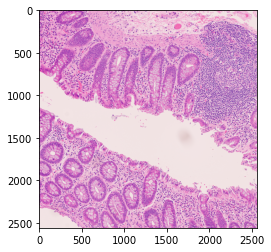

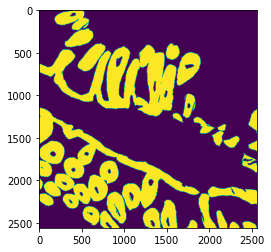

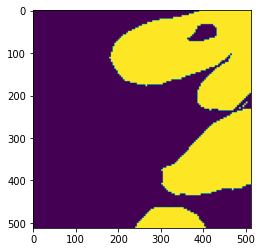

2.0


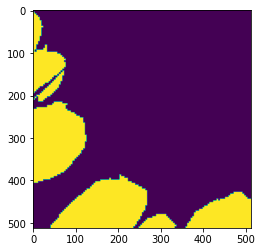

2.0


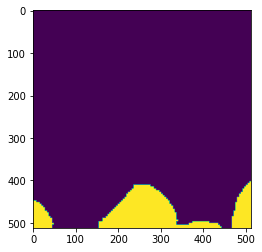

2.0


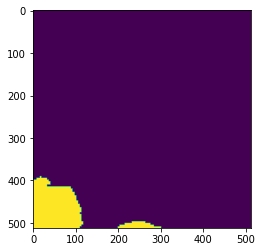

2.0


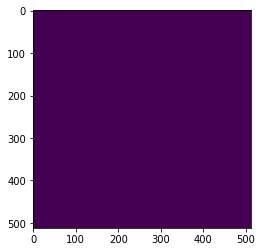

0.0


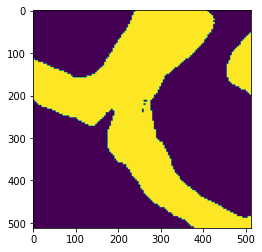

2.0


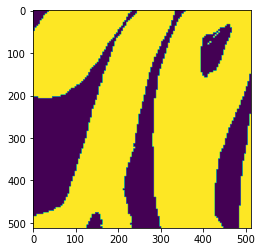

2.0


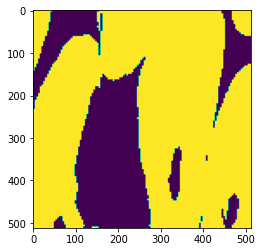

2.0


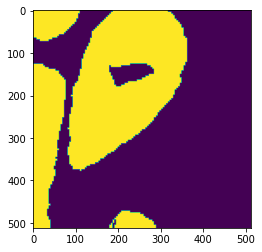

2.0


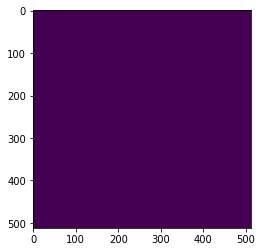

0.0


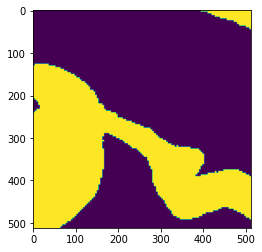

2.0


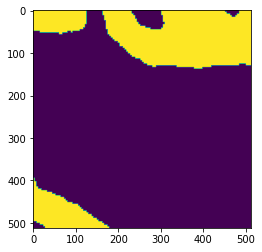

2.0


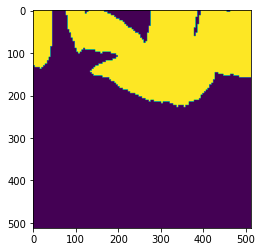

2.0


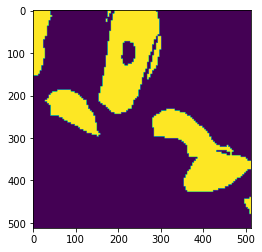

2.0


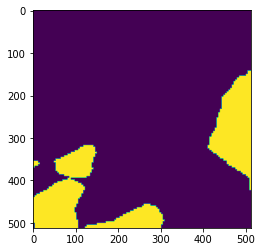

2.0


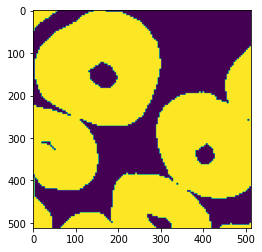

2.0


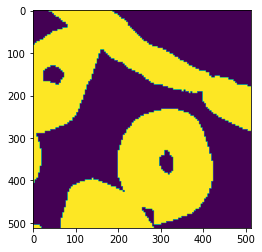

2.0


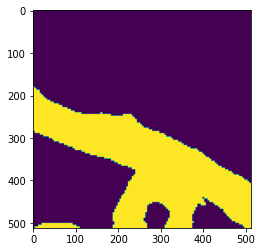

2.0


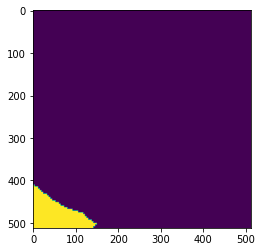

2.0


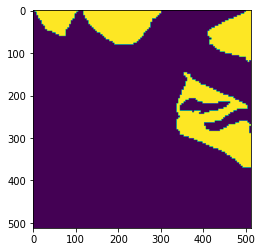

2.0


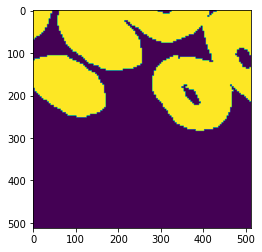

2.0


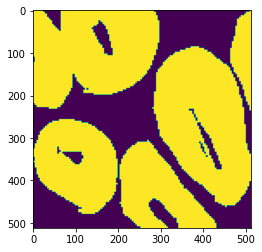

2.0


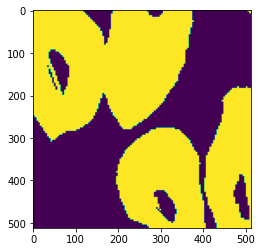

2.0


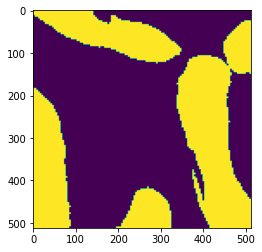

2.0


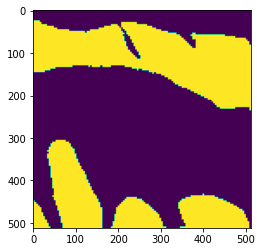

2.0


In [7]:
num_split = 5
target_width = 512
target_shape = (target_width, target_width)
image_dir = '../datasets/pathologocal_images_JPEG'
label_dir = '../datasets/ndarray_labels'
label_path_list = glob.glob(label_dir+'/*')
label_path = label_path_list[100]
image_name = os.path.splitext(os.path.basename(label_path))[0]
image_path = os.path.join(image_dir, image_name+'.jpg')
outer_target_width = target_width*num_split
outer_target_shape = (outer_target_width, outer_target_width)
image = Image.open(image_path)
image = image.resize(outer_target_shape)
image_array = np.array(image)
label_array = np.load(label_path)
label_image = Image.fromarray(label_array).resize(outer_target_shape, Image.NEAREST)
label_array = np.array(label_image)

plt.imshow(image_array)
plt.show()
plt.imshow(label_array)
plt.show()

for row in range(num_split):
    for column in range(num_split):
        cropped_image_array = image_array[
            row*target_width:(row+1)*target_width, 
            column*target_width:(column+1)*target_width
        ]
        plt.imshow(cropped_image_array)
        cropped_label_image_array = label_array[
            row*target_width:(row+1)*target_width, 
            column*target_width:(column+1)*target_width
        ]
        plt.imshow(cropped_label_image_array)
        plt.show()
        print(np.max(cropped_label_image_array))
# plt.show()
# distorted_image = elastic_transform(image_array)
# plt.imshow(distorted_image)

In [12]:
def elastic_transform(image):
    image = np.array(image)
    alpha = random.randint(0,100)
    sigma = random.choice([8,9,10])
    shape = image.shape
    shape_size = shape[:2]
    dx = gaussian_filter((np.random.random(shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((np.random.random(shape) * 2 - 1), sigma) * alpha
    dz = np.zeros_like(dx)
    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))
    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)